# Data exploration for CSI raw data

data is available at https://www.californiadgstats.ca.gov/download/interval_data/Raw_Interval_Dataset.zip


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Read the csv data
We use the following profile of data.
`PGE-SASH-4101`:  
* Zip Code: 95122 San Jose, California https://goo.gl/maps/zCsdjqUbtYF2

In [2]:
%%time
df = pd.read_csv("../data/CSIraw/PGE_No_Load_StartThru2016Q4.csv",header=0,parse_dates=[3])

CPU times: user 53.6 s, sys: 21.2 s, total: 1min 14s
Wall time: 1min 18s


In [3]:
df.head()

,ID,Inctv_type,pa,LocalDateTime,kWh,Flag
0,A-1611,EPBB,PG&E,26AUG10:00:00:00,0.01625,M
1,A-1611,EPBB,PG&E,26AUG10:00:15:00,0.01650,M
2,A-1611,EPBB,PG&E,26AUG10:00:30:00,0.01625,M
3,A-1611,EPBB,PG&E,26AUG10:00:45:00,0.01600,M
4,A-1611,EPBB,PG&E,26AUG10:01:00:00,0.01600,M


In [4]:
df.dtypes, df.columns, df.shape

(ID                object
 Inctv_type        object
 pa                object
 LocalDateTime     object
 kWh              float64
 Flag              object
 dtype: object,
 Index(['ID', 'Inctv_type', 'pa', 'LocalDateTime', 'kWh', 'Flag'], dtype='object'),
 (36053945, 6))

In [279]:
pge_df = df[df['ID']=='PGE-SASH-4101']

In [280]:
from datetime import datetime
datestr1='26AUG10:00:45:00'
datetime.strptime(datestr1, '%d%b%y:%H:%M:%S')

datetime.datetime(2010, 8, 26, 0, 45)

In [281]:
pge_df['datetime'] = pd.to_datetime(pge_df['LocalDateTime'],format='%d%b%y:%H:%M:%S',errors='ignore')
pge_df = pge_df.drop(columns=['LocalDateTime'])
pge_df.head()

/Users/taku/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,ID,Inctv_type,pa,kWh,Flag,datetime
35791621,PGE-SASH-4101,EPBB,PG&E,0.0,M,2011-12-21 00:00:00
35791622,PGE-SASH-4101,EPBB,PG&E,0.0,M,2011-12-21 00:15:00
35791623,PGE-SASH-4101,EPBB,PG&E,0.0,M,2011-12-21 00:30:00
35791624,PGE-SASH-4101,EPBB,PG&E,0.0,M,2011-12-21 00:45:00
35791625,PGE-SASH-4101,EPBB,PG&E,0.0,M,2011-12-21 01:00:00


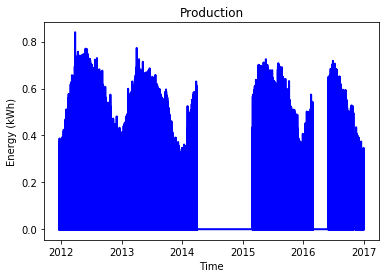

In [282]:
# plotting
bp_x = pge_df['datetime']
bp_y = pge_df['kWh']

# Make the plot
plt.plot(bp_x, bp_y, linewidth=2, linestyle="-",
         color="blue") # , label=r"Legend label $\sin(x)$"
plt.xlabel(r"Time")
plt.ylabel(r"Energy (kWh)")
plt.title(r"Production")
# plt.legend(loc="lower left")
plt.show()

There are some missing data!!

deal with that

In [283]:
# set the range of datetime
idx = pd.date_range(pge_df['datetime'].iloc[0],pge_df['datetime'].iloc[-1],freq='15min')

# set the datetime as index
pge_df = pge_df.set_index('datetime')
# reindexing to fill the nans
pge_df=pge_df.reindex(idx)
pge_df.shape

(176448, 5)

In [284]:
pge_df[pge_df['kWh'].isnull() == True].shape

(42635, 5)

There are 42635 missing rows!

In [285]:
pge_df[pge_df['kWh'].isnull() == True].head()

,ID,Inctv_type,pa,kWh,Flag
2011-12-31 23:45:00,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN


Ignore the date with `NaN` data

In [320]:
unuseful_date = pge_df[pge_df['kWh'].isnull() == True].index.date 
unuseful_date.shape

(42635,)

In [319]:
pge_df.index.date.shape

(176448,)

use only the useful data  
**take some time**

In [334]:
%%time
pge_df = pge_df[~np.isin(pge_df.index.date,unuseful_date)]

CPU times: user 2min 7s, sys: 906 ms, total: 2min 7s
Wall time: 2min 7s


In [335]:
# number of days
129792/96 

1352.0

## Split by seasons

We split the data by seasons:
* Spring: 3-5
* Summer: 6-8
* Fall: 9-11
* Winter: 12-2

In [336]:
summer = [6,7,8];fall = [9,10,11];spring = [3,4,5]; winter = [12,1,2]
pv_summer = pge_df[pge_df.index.month.isin(summer)]['kWh'].values*4 # to convert average power (kW)
pv_summer = pv_summer.reshape(-1,96)
pv_fall = pge_df[pge_df.index.month.isin(fall)]['kWh'].values*4 # to convert average power (kW)
pv_fall = pv_fall.reshape(-1,96)
pv_spring = pge_df[pge_df.index.month.isin(spring)]['kWh'].values*4 # to convert average power (kW)
pv_spring = pv_spring.reshape(-1,96)
pv_winter = pge_df[pge_df.index.month.isin(winter)]['kWh'].values*4 # to convert average power (kW)
pv_winter = pv_winter.reshape(-1,96)

pv_summer.shape,pv_fall.shape, pv_spring.shape, pv_winter.shape

((356, 96), (339, 96), (297, 96), (360, 96))

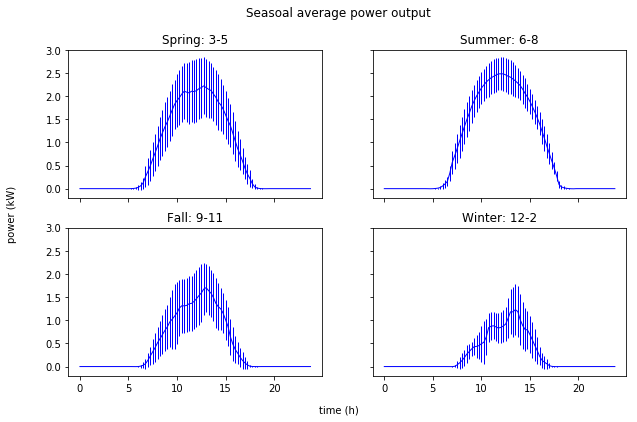

In [338]:
# plot the mean production with standard deviation
stages = np.linspace(start=0,stop=23.75,num=96)
f, axarr = plt.subplots(2, 2,figsize=(10, 6), sharex=True, sharey=True)
axarr[0,0].errorbar(stages,pv_spring.mean(axis=0), yerr=pv_spring.std(axis=0), linewidth=1, linestyle="-",color="blue")
axarr[0, 0].set_title('Spring: 3-5')

axarr[0,1].errorbar(stages,pv_summer.mean(axis=0), yerr=pv_summer.std(axis=0), linewidth=1, linestyle="-",color="blue")
axarr[0,1].set_title('Summer: 6-8')

axarr[1,0].errorbar(stages,pv_fall.mean(axis=0), yerr=pv_fall.std(axis=0), linewidth=1, linestyle="-",color="blue")
axarr[1,0].set_title('Fall: 9-11')

axarr[1,1].errorbar(stages,pv_winter.mean(axis=0), yerr=pv_winter.std(axis=0), linewidth=1, linestyle="-",color="blue")
axarr[1,1].set_title('Winter: 12-2')

f.text(0.5, 0.04, 'time (h)', ha='center')
f.text(0.04, 0.5, 'power (kW)', va='center', rotation='vertical')
f.suptitle("Seasoal average power output")
plt.show()

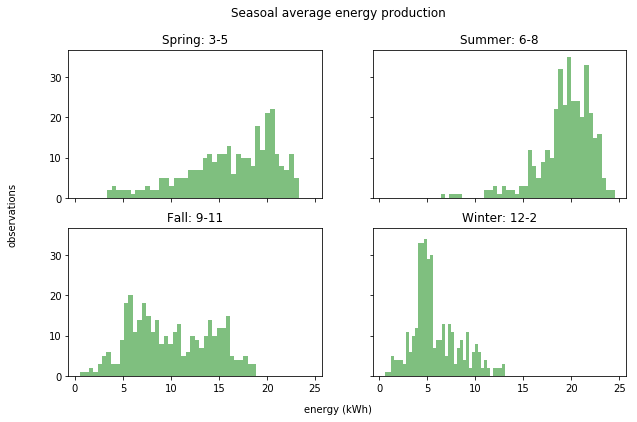

In [339]:
# histogram of the average production per day
num_bins = 40
f, axarr = plt.subplots(2, 2,figsize=(10, 6), sharex=True, sharey=True)
axarr[0,0].hist(pv_spring.sum(axis=1)/4, num_bins, facecolor="green", alpha=0.5)
axarr[0, 0].set_title('Spring: 3-5')

axarr[0,1].hist(pv_summer.sum(axis=1)/4, num_bins, facecolor="green", alpha=0.5)
axarr[0,1].set_title('Summer: 6-8')

axarr[1,0].hist(pv_fall.sum(axis=1)/4, num_bins,  facecolor="green", alpha=0.5)
axarr[1,0].set_title('Fall: 9-11')

axarr[1,1].hist(pv_winter.sum(axis=1)/4, num_bins, facecolor="green", alpha=0.5)
axarr[1,1].set_title('Winter: 12-2')

f.text(0.5, 0.04, 'energy (kWh)', ha='center')
f.text(0.04, 0.5, 'observations', va='center', rotation='vertical')
f.suptitle("Seasoal average energy production")
plt.show()

#### Observation
* Production level varies greatly depending on the season. 
* The standard deviation during **summer** is the smallest (histogram is centered) -> **nice to model the PV scenario generator**

In [348]:
dataname = 'PGE-SASH-4101'
writecsvname = 'PGE-SASH-4101' + '_raw_winter.csv'
pd.DataFrame(pv_winter).to_csv(writecsvname, header=False, index=False)
writecsvname = 'PGE-SASH-4101' + '_raw_spring.csv'
pd.DataFrame(pv_spring).to_csv(writecsvname, header=False, index=False)
writecsvname = 'PGE-SASH-4101' + '_raw_summer.csv'
pd.DataFrame(pv_summer).to_csv(writecsvname, header=False, index=False)
writecsvname = 'PGE-SASH-4101' + '_raw_fall.csv'
pd.DataFrame(pv_fall).to_csv(writecsvname, header=False, index=False)


In [340]:
# pge_df['stages'] = pge_df['datetime'].dt.hour*4 + pge_df['datetime'].dt.minute/15
# pge_df['stages'].astype(np.int64).head()

In [341]:
# useful_date = pge_df[(pge_df['stages'] == 96)]['datetime'].dt.date
# pge_df[pge_df['datetime'].dt.date.isin(useful_date)]

In [209]:
# pge_df['datetime'].resample("D",how='sum')
# df_temp = pge_df['stages'].groupby([pge_df['datetime'].dt.date]).sum()

In [210]:
# useful_date = []
# for l in df_temp.index.tolist():
#     if df_temp[l] == 4560.0:
#         useful_date.append(l)

In [211]:
# temp_pge_df = pge_df[pge_df['datetime'].dt.date.isin(useful_date)]

In [212]:
# idx = pd.date_range(temp_pge_df['datetime'].iloc[0],temp_pge_df['datetime'].iloc[-1],freq='15min')
# temp_pge_df = temp_pge_df.set_index('datetime')
# temp_pge_df=temp_pge_df.reindex(idx)